# 感受率計算
RPAまたはFLEX近似に基づいて多極子感受率を計算するプログラムを作成します。ここでは、多くの研究で用いられている松原グリーン関数を用いた計算方法を実装します。

## 準備
まずは必要なパッケージを読み込みます。
もしパッケージがインストールされていない場合は、
```julia
using Pkg
Pkg.add("Foo") 
```
とすることでFoo.jlをインストールすることができます。
また、$2 \times 2$単位行列$\hat{\sigma}_0$およびパウリ行列$\hat{\sigma}_1, \hat{\sigma}_2, \hat{\sigma}_3$を用意しておきます。

In [1]:
using LinearAlgebra
using FFTW
using Optim
using Plots
using LaTeXStrings

const σ0 = ComplexF64[1 0; 0 1]
const σ1 = ComplexF64[0 1; 1 0]
const σ2 = ComplexF64[0 -1im; 1im 0]
const σ3 = ComplexF64[1 0; 0 -1]
;

次に、計算に必要なパラメータを構造体(struct)を使ってまとめておきます。

In [2]:
mutable struct Parameters
    mode::String
    mix::Float64
    g_sfc_tol::Float64

    system::String
    nk1::Int64
    nk2::Int64
    nk3::Int64
    nω::Int64
    T::Float64
    β::Float64
    n_fill::Float64
    nspin::Int64
    norb::Int64
    nwan::Int64
    U::Float64
    pos::Vector{Vector{Float64}}
end

"パラメータを設定する関数"
function Parameters(
        system::String,
        n_fill::Float64,
        U::Float64,
        T::Float64,
        mode::String;
        nk1::Int64,
        nk2::Int64,
        nk3::Int64,
        nω::Int64,
    )::Parameters

    mix::Float64 = 0.2 # グリーン関数のイテレーションで新しいGをどのくらい混ぜるかを決める値

    # 収束条件を決める値(tolerance)
    g_sfc_tol::Float64 = 1e-6

    # 物理系に関するパラメータ
    β::Float64 = 1/T           # 逆温度
    n_fill::Float64 = n_fill   # 電子数密度
    nspin::Int64 = 1           # スピン自由度
    norb::Int64 = (
        if system == "square"
            1
        elseif system == "modified_square"
            2
        end
    )                          # 軌道・副格子自由度
    nwan::Int64 = nspin * norb # 全内部自由度

    # 単位胞内の副格子の内部座標
    pos::Vector{Vector{Float64}} = (
        if system == "square"
            [
                [0.0, 0.0, 0.0]
            ]
        elseif system == "modified_square"
            [
                [0.0, -0.5, 0.0], # 副格子a
                [-0.5, 0.0, 0.0]  # 副格子b
            ]
        end
    )

    return Parameters(
        mode, mix, g_sfc_tol,
        system, nk1, nk2, nk3, nω, T, β, n_fill, nspin, norb, nwan, U, pos
    )
end
;

各波数点におけるハミルトニアンおよびその固有値・固有ベクトルを計算します。また、後で用いる松原振動数のメッシュを定義しておきます。

In [3]:
mutable struct Mesh
    prmt::Parameters

    hk::Array{ComplexF64, 5}
    ek0::Array{Float64, 4}
    ek::Array{Float64, 4}
    uk::Array{ComplexF64, 5}
    μ::Float64
    emin::Float64
    emax::Float64
    W::Float64
    U_mat::Matrix{Float64}

    ω_f::Vector{Float64}
    ω_b::Vector{Float64}
    iω0_f::Int64
    iω0_b::Int64
end

"ハミルトニアン・松原振動数のメッシュを設定する関数"
function Mesh(p::Parameters)::Mesh
    # ハミルトニアンとその固有値・固有ベクトルを計算
    hk::Array{ComplexF64, 5} = set_hamiltonian_matrix(p)
    ek0 = Array{Float64, 4}(undef, p.nk1, p.nk2, p.nk3, p.nwan)
    uk = zeros(ComplexF64, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1
        tmpe, tmpu = eigen(@view(hk[ik1, ik2, ik3, :, :]))
        ek0[ik1, ik2, ik3, :] .= real.(tmpe)
        uk[ik1, ik2, ik3, :, :] .= tmpu
    end

    μ::Float64 = set_μ(p, ek0) # 化学ポテンシャル
    ek::Array{Float64, 4} = ek0 .- μ
    emin::Float64 = minimum(ek0)
    emax::Float64 = maximum(ek0)
    W::Float64 = emax - emin

    U_mat::Matrix{Float64} = set_interaction(p) # 相互作用を表す行列

    # 松原振動数(フェルミオンとボソン)
    ω_f::Vector{Float64} = [
        (2iω+1) * π * p.T for iω in (-p.nω÷2):(p.nω÷2-1)
    ]
    ω_b::Vector{Float64} = [
        2iω * π * p.T for iω in (-p.nω÷2):(p.nω÷2-1)
    ]
    iω0_f = iω0_b = p.nω÷2+1

    return Mesh(
        p, hk, ek0, ek, uk, μ, emin, emax, W, U_mat, ω_f, ω_b, iω0_f, iω0_b
    )
end

"一体ハミルトニアンの定義"
function set_hamiltonian_matrix(p::Parameters)
    # 遷移積分
    t1::Float64 = 0.0
    t2::Float64 = 0.0
    if p.system == "square"
        t1 = 1.0
    elseif p.system == "modified_square"
        t1 = 1.0
        t2 = 0.15
    end

    # systemの値に応じてハミルトニアンを定義(スピン軌道相互作用は無視し、遷移積分のみ)
    hk = Array{ComplexF64, 5}(undef, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1
        k1::Float64 = (2π*(ik1-1)) / p.nk1
        k2::Float64 = (2π*(ik2-1)) / p.nk2

        if p.system == "square"
            hk[ik1, ik2, ik3, :, :] .= - 2t1 * (cos(k1) + cos(k2))
        elseif p.system == "modified_square"
            ### 畳み込みを計算するためにFFTを利用するので、ブリルアンゾーンの周期性を満たすハミルトニアンを定義する
            f1::ComplexF64 = (1 + cis(k1)) * (1 + cis(-k2))
            hk[ik1, ik2, ik3, :, :] .= (
                - t1 .* (real(f1) .* σ1 .- imag(f1) .* σ2)
                .- 2t2 * cos(k1) * cos(k2) .* σ0
                .- 2t2 * sin(k1) * sin(k2) .* σ3
            )
        end
    end

    hk
end

"化学ポテンシャルの計算"
function set_μ(p::Parameters, ek::Array{Float64, 4})
    # 軌道・副格子あたりの電子数
    n_0::Float64 = p.n_fill

    # 与えられた電子数密度になるようにBrent法を用いて化学ポテンシャルを決定する
    res = optimize(
        μ -> (2/p.nspin * calc_electron_density(p, ek, μ) - n_0)^2,
        3*minimum(ek), 3*maximum(ek), rel_tol=1e-4, Brent()
    )
    Optim.minimizer(res)[1]
end

"電子数密度の計算"
function calc_electron_density(p::Parameters, ek::Array{Float64, 4}, μ::Float64)
    E = fill(one(Float64), size(ek)...)
    sum(E ./ (E .+ exp.(p.β .* (ek .- μ)))) / (p.nk1 * p.nk2 * p.nk3 * p.norb)
end

"相互作用行列の計算"
function set_interaction(p::Parameters)
    # オンサイトハバード相互作用の計算
    ## スピン自由度の有無(スピン軌道結合を入れるか入れないか)によって表式が異なる
    U_mat::Matrix{Float64} = zeros(Float64, p.nwan^2, p.nwan^2)
    if p.nspin == 1
        for ζ in 1:p.norb
            # udud, dudu
            ξ12::Int = p.nwan*(ζ-1) + ζ
            ξ34::Int = p.nwan*(ζ-1) + ζ
            U_mat[ξ12, ξ34] += p.U
        end
    elseif p.nspin == 2
        for ζ in 1:p.norb, s in 1:p.nspin
            sbar::Int = 3 - s

            # udud, dudu
            ξ12::Int = p.nwan*((p.nspin*(ζ-1) + s)-1) + p.nspin*(ζ-1) + sbar
            ξ34::Int = p.nwan*((p.nspin*(ζ-1) + s)-1) + p.nspin*(ζ-1) + sbar
            U_mat[ξ12, ξ34] += p.U

            # uudd, dduu
            ξ12 = p.nwan*((p.nspin*(ζ-1) + s)-1) + p.nspin*(ζ-1) + s
            ξ34 = p.nwan*((p.nspin*(ζ-1) + sbar)-1) + p.nspin*(ζ-1) + sbar
            U_mat[ξ12, ξ34] -= p.U
        end
    end

    U_mat
end
;

この先のグリーン関数の計算では高速フーリエ変換(FFT)を多用するので、FFTW.jlパッケージを用いて$\tau \leftrightarrow \mathrm{i}\omega_n (\mathrm{i}\varepsilon_m), \, r \leftrightarrow k$のフーリエ変換を行う関数を実装しておきます。(FFTWは古くからあるライブラリなので、様々な言語で使えるようになっているはずです)

$\tau \leftrightarrow \mathrm{i}\omega_n (\mathrm{i}\varepsilon_m)$の変換ではそのままFFTを行うのではなく、ボソン・フェルミオンに応じて異なる位相因子を掛ける必要があることに注意します。

In [4]:
# 高速フーリエ変換
"τからiωへのフーリエ変換"
function τ_to_ωn(p::Parameters, isboson::Bool, obj_τ::Array{ComplexF64, n}) where n
    phase::Vector{ComplexF64} = (
        isboson ?
        [(-1)^(iτ-1) for iτ in 1:p.nω] : # ボソン
        [(-1)^(iτ-1) * cispi((iτ-1)/p.nω) for iτ in 1:p.nω] # フェルミオン
    )

    obj_ωn::Array{ComplexF64, n} = p.β .* ifft(phase .* obj_τ, [1])
    return obj_ωn
end

"iωからτへのフーリエ変換"
function ωn_to_τ(p::Parameters, isboson::Bool, obj_ωn::Array{ComplexF64, n}) where n
    phase::Vector{ComplexF64} = (
        isboson ?
        [(-1)^(iτ-1) for iτ in 1:p.nω] : # ボソン
        [(-1)^(iτ-1) * cispi(-(iτ-1)/p.nω) for iτ in 1:p.nω] # フェルミオン
    )

    obj_τ::Array{ComplexF64, n} = p.T .* phase .* fft(obj_ωn, [1])
    return obj_τ
end

"波数空間から実空間へのフーリエ変換"
function k_to_r(p::Parameters, obj_k::Array{ComplexF64, n}) where n
    obj_r::Array{ComplexF64, n} = ifft(obj_k, [2, 3, 4])
    return obj_r
end

"実空間から波数空間へのフーリエ変換"
function r_to_k(p::Parameters, obj_r::Array{ComplexF64, n}) where n
    obj_k::Array{ComplexF64, n} = fft(obj_r, [2, 3, 4])
    return obj_k
end
;

## グリーン関数
計算で用いる様々なグリーン関数を格納する構造体を用意し、対応する行列を確保しておきます。

In [5]:
mutable struct Gfunction
    U_pval::Float64
    μ::Float64

    g0iωk::Array{ComplexF64, 6}
    giωk::Array{ComplexF64, 6}
    g0iτk::Array{ComplexF64, 6}
    giτr::Array{ComplexF64, 6}
    χ0iβ0::Array{ComplexF64, 2}
    χ0iωk::Array{ComplexF64, 6}
    χiωk::Array{ComplexF64, 6}
    Viτ_dum::Array{ComplexF64, 3}
    Viω_dum::Array{ComplexF64, 3}
    Σiωk::Array{ComplexF64, 6}
end

"グリーン関数の初期化"
function Gfunction(m::Mesh)::Gfunction
    p::Parameters = m.prmt
    μ::Float64 = m.μ # 相互作用なしの場合に求めた化学ポテンシャル

    # 行列の確保
    g0iωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    giωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    g0iτk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    giτr = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    χ0iβ0 = Array{ComplexF64, 2}(undef, p.nwan^2, p.nwan^2)
    χ0iωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan^2, p.nwan^2)
    χiωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan^2, p.nwan^2)
    Viτ_dum = Array{ComplexF64, 3}(undef, p.nω, p.nwan^2, p.nwan^2)
    Viω_dum = Array{ComplexF64, 3}(undef, p.nω, p.nwan^2, p.nwan^2)
    Σiωk::Array{ComplexF64, 6} = zeros(ComplexF64, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)

    g = Gfunction(p.U, μ, g0iωk, giωk, g0iτk, giτr, χ0iβ0, χ0iωk, χiωk, Viτ_dum, Viω_dum, Σiωk)

    return g
end

function calc_Gfunction!(m::Mesh, g::Gfunction)
    # G_0, G, χ_0, χ の計算
    set_g0iτk!(m, g, g.μ)
    set_giωk!(m, g, g.μ)
    set_giτr!(m, g)
    set_χ0iωk!(m, g)
    set_χiωk!(m, g)

    if m.prmt.mode == "FLEX"
        FLEXcheck = solve_FLEX!(m, g)
        FLEXcheck === missing && println("FLEX not converged!")
    end
end
;

一粒子グリーン関数を計算する関数を定義します。

$G(\mathrm{i}\varepsilon_m, \boldsymbol{k}) \to G(\tau, \boldsymbol{k})$のフーリエ変換を行う際には細心の注意を払う必要があります。すなわち、本来$G(\mathrm{i}\varepsilon_m, \boldsymbol{k})$は振動数空間で周期的ではなく、$(\mathrm{i}\varepsilon_m)^{-1}$で減衰する関数であり、それに対応して$G(\tau, \boldsymbol{k})$は$\tau = 0$で不連続な関数になっています。単にFFTを行うだけではこのような特異的な性質をうまく取り扱うことができないため、自己エネルギーを含まない裸のグリーン関数$G_0(\mathrm{i}\varepsilon_m, \boldsymbol{k})$ ($(\mathrm{i}\varepsilon_m)^{-1}$の寄与)を一度差し引いてからFFTを行い、解析的に計算した$G_0(\tau, \boldsymbol{k})$を後で足す、ということを行います。テクニカルな方法になりますが、グリーン関数の数値計算を行う人たちの間ではこのような問題はよく知られています。

なお、後に感受率・相互作用バーテックス・自己エネルギーを計算する際にも同様の問題が発生するので、そこでもFFTを行う前に手を加えている箇所が多々あります。これ以上詳しくは述べませんが、例えば以下の文献が参考になると思います：
- J. J. Deisz, D. W. Hess, and J. W. Serene, [Phys. Rev. B 66, 014539 (2002)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.66.014539)
- H. Tamaki, Y. Ohashi, and K. Miyake, [Phys. Rev. A 77, 063616 (2008)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.77.063616)

また、当然ながら $r \leftrightarrow k$のフーリエ変換ではこのような面倒な手続きを考える必要はなく、素直にFFTを行えば大丈夫です。

In [6]:
"フェルミ分布関数"
function fermi(E::Real, T::Real)
    # expを使うよりtanhを使う方が安定する
    0.5 * (1 - tanh(E / (2T)))
end

"裸のグリーン関数G_0(τ, k)"
function set_g0iτk!(m::Mesh, g::Gfunction, μ::Float64)
    p::Parameters = m.prmt

    # G_0(τ, k)をハミルトニアンの固有値と固有ベクトルを用いて求める
    g.g0iτk .= zeros(ComplexF64, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1, iτ in 1:p.nω
        τ::Float64 = p.β * (iτ - 1) / p.nω

        for α in 1:p.nwan
            ek::Float64 = m.ek0[ik1, ik2, ik3, α] - μ
            tmp::Float64 = (
                ek > 0 ?
                - fermi(-ek, p.T) * exp(-ek * τ) :
                - fermi( ek, p.T) * exp( ek * (p.β - τ))
            )

            for ξ2 in 1:p.nwan, ξ1 in 1:p.nwan
                g.g0iτk[iτ, ik1, ik2, ik3, ξ1, ξ2] += (
                    tmp * m.uk[ik1, ik2, ik3, ξ1, α] * conj(m.uk[ik1, ik2, ik3, ξ2, α])
                )
            end
        end
    end

    g.g0iτk
end

"裸のグリーン関数G_0(iϵ, k)と自己エネルギーの入ったグリーン関数G(iϵ, k)"
function set_giωk!(m::Mesh, g::Gfunction, μ::Float64)
    id = Matrix{ComplexF64}(I, m.prmt.nwan, m.prmt.nwan) # 単位行列

    # 裸のグリーン関数
    for ik3 in 1:m.prmt.nk3, ik2 in 1:m.prmt.nk2, ik1 in 1:m.prmt.nk1, iω in 1:m.prmt.nω
        g.g0iωk[iω, ik1, ik2, ik3, :, :] .= @views(
            (1im*m.ω_f[iω] + μ) .* id .- m.hk[ik1, ik2, ik3, :, :]
        ) \ I
    end

    # 自己エネルギーを考慮したグリーン関数
    for ik3 in 1:m.prmt.nk3, ik2 in 1:m.prmt.nk2, ik1 in 1:m.prmt.nk1, iω in 1:m.prmt.nω
        g.giωk[iω, ik1, ik2, ik3, :, :] .= @views(
            (1im*m.ω_f[iω] + μ) .* id .- m.hk[ik1, ik2, ik3, :, :]
            .- g.Σiωk[iω, ik1, ik2, ik3, :, :]
        ) \ I
    end

    g.g0iωk, g.giωk
end

"グリーン関数の対称化"
function symmetrize_giωk!(g::Gfunction)
    # G(k, iω) = G(-k, iω)^T
    giωk_revk::Array{ComplexF64, 6} = permutedims(
        reverse(
            circshift(g.giωk, (0, -1, -1, -1, 0, 0)),
            dims=(2, 3, 4)
        ),
        (1, 2, 3, 4, 6, 5)
    )
    g.giωk .= (g.giωk .+ giωk_revk) ./ 2.0
end

"グリーン関数G(τ, r)"
function set_giτr!(m::Mesh, g::Gfunction)
    # FT: G(iϵ, k) -> G(τ, k)
    ## (iϵ)^{-1}の寄与を避けるため、G_0を引いてフーリエ変換して後で戻す
    giτk::Array{ComplexF64, 6} = ωn_to_τ(m.prmt, false, g.giωk .- g.g0iωk) .+ g.g0iτk

    # FT: G(τ, k) -> G(τ, r)
    g.giτr .= k_to_r(m.prmt, giτk)
end
;

感受率を計算する関数を定義します。

$\chi_0(\mathrm{i}\omega_n, \boldsymbol{q})$は2つの一粒子グリーン関数の畳み込み和として定義されますが、フーリエ変換で$(\tau, \boldsymbol{R})$空間へ持っていくことでただの積になります。元の定義で愚直に畳み込み和を計算するよりも、FFTを利用して一度$(\tau, \boldsymbol{R})$へ持っていって積を計算し、もう一度FFTを使って$(\mathrm{i}\omega_n, \boldsymbol{q})$空間へ戻す、という操作を行った方が速く計算が実行できることが知られています。(このような事情があるため、FFTを行う準備を色々としていたのでした。)

In [7]:
"既約感受率χ_0(iω, q)"
function set_χ0iωk!(m::Mesh, g::Gfunction)
    p::Parameters = m.prmt

    # -G(-τ, -r) = G(β-τ, -r)
    giτr_rev::Array{ComplexF64, 6} = reverse(
        circshift(g.giτr, (-1, -1, -1, -1, 0, 0)),
        dims=(1, 2, 3, 4)
    )

    ## -G(τ=-0, -r)_{1, 2} = -(δ_{r, 0} δ_{1, 2} + G(+0, -r)_{1, 2})
    for iξ in 1:p.nwan
        giτr_rev[1, 1, 1, 1, iξ, iξ] += 1
    end
    giτr_rev[1, :, :, :, :, :] .*= -1

    # 2つのグリーン関数の積
    ## χ_0(τ, r) = - G(τ, r) G(-τ, -r)
    χ0iτr = zeros(ComplexF64, p.nω, p.nk1, p.nk2, p.nk3, p.nwan^2, p.nwan^2)
    for ξ4 in 1:p.nwan, ξ3 in 1:p.nwan, ξ2 in 1:p.nwan, ξ1 in 1:p.nwan
        ξ12::Int64 = p.nwan * (ξ1-1) + ξ2
        ξ34::Int64 = p.nwan * (ξ3-1) + ξ4
        χ0iτr[:, :, :, :, ξ12, ξ34] .+= @views(
            g.giτr[:, :, :, :, ξ1, ξ3] .* giτr_rev[:, :, :, :, ξ4, ξ2]
        )
    end

    ## χ0(τ=β-0, r=0)_{12, 34} = χ0(-0, 0)_{12, 34} = - (δ_{1, 3} + G(+0, 0)_{1, 3}) G(+0, 0)_{4, 2}
    g.χ0iβ0 .= zeros(ComplexF64, p.nwan^2, p.nwan^2)
    for ξ4 in 1:p.nwan, ξ3 in 1:p.nwan, ξ2 in 1:p.nwan, ξ1 in 1:p.nwan
        ξ12::Int64 = p.nwan * (ξ1-1) + ξ2
        ξ34::Int64 = p.nwan * (ξ3-1) + ξ4
        g.χ0iβ0[ξ12, ξ34] += giτr_rev[1, 1, 1, 1, ξ1, ξ3] * g.giτr[1, 1, 1, 1, ξ4, ξ2]
    end

    # V_dum(τ)
    for iτ in 1:p.nω
        g.Viτ_dum[iτ, :, :] .= (1/p.nspin) .* m.U_mat * @view(χ0iτr[iτ, 1, 1, 1, :, :]) * m.U_mat
    end

    # FFTにかける量として、(iω)^{-1}の寄与を避けたものを定義しておく
    χ0iτr_FFT = similar(χ0iτr)
    for iτ in 1:p.nω
        χ0iτr_FFT[iτ, :, :, :, :, :] .= @views(
            2 .* χ0iτr[iτ, :, :, :, :, :]
            .- χ0iτr[mod(iτ+1, 1:p.nω), :, :, :, :, :]
            .- χ0iτr[mod(iτ-1, 1:p.nω), :, :, :, :, :]
        )
    end
    χ0iτr_FFT[1, 1, 1, 1, :, :]    .+= g.χ0iβ0 .- @view(χ0iτr[1, 1, 1, 1, :, :])
    χ0iτr_FFT[p.nω, 1, 1, 1, :, :] .+= @view(χ0iτr[1, 1, 1, 1, :, :]) .- g.χ0iβ0

    # FT: χ_0(τ, r) -> χ_0(iω, r)
    χ0iωr::Array{ComplexF64, 6} = τ_to_ωn(p, true, χ0iτr_FFT)
    for iω in 1:p.nω
        if iω != m.iω0_b
            ### FFTで得られたのは(iω)^{-2}の寄与
            χ0iωr[iω, :, :, :, :, :] .*= (p.nω * p.T / m.ω_b[iω])^2

            ### r = 0のとき、(iω)^{-1}の寄与を加える
            χ0iωr[iω, 1, 1, 1, :, :] .+= (g.χ0iβ0 .- @view(χ0iτr[1, 1, 1, 1, :, :])) ./ (1im*m.ω_b[iω])
        else
            ### ボソンの場合、ゼロ振動数は特別に扱う必要がある
            χ0iωr[iω, :, :, :, :, :] .= zero(ComplexF64)
            for iτ in 1:p.nω
                χ0iωr[iω, :, :, :, :, :] .+= (p.β / p.nω) .* χ0iτr[iτ, :, :, :, :, :]
            end
            χ0iωr[iω, 1, 1, 1, :, :] .+= (p.β / 2p.nω) .* (g.χ0iβ0 .- @view(χ0iτr[1, 1, 1, 1, :, :]))
        end
    end

    # V_dum(iω)
    for iω in 1:p.nω
        g.Viω_dum[iω, :, :] .= (1/p.nspin) .* m.U_mat * @view(χ0iωr[iω, 1, 1, 1, :, :]) * m.U_mat
    end

    # FT: χ_0(iω, r) -> χ_0(iω, q)
    g.χ0iωk .= r_to_k(p, χ0iωr)
end

"一般化感受率χ(iω, q)"
function set_χiωk!(m::Mesh, g::Gfunction)
    # RPA (FLEX近似) での感受率
    ## χ = [1 - χ_0 U]^(-1) χ_0
    id = Matrix{ComplexF64}(I, m.prmt.nwan^2, m.prmt.nwan^2) # 単位行列
    for ik3 in 1:m.prmt.nk3, ik2 in 1:m.prmt.nk2, ik1 in 1:m.prmt.nk1, iω in 1:m.prmt.nω
        denom::Matrix{ComplexF64} = copy(id)
        @views mul!(denom, g.χ0iωk[iω, ik1, ik2, ik3, :, :], m.U_mat, -1, 1)
        g.χiωk[iω, ik1, ik2, ik3, :, :] .= denom \ @view(g.χ0iωk[iω, ik1, ik2, ik3, :, :])
    end

    g.χiωk
end
;

相互作用バーテックスと、それを用いて自己エネルギーを計算する関数を実装します。ここでも、FFTを利用して畳み込み和をただの積に変換するテクニックを使用しています。

In [8]:
"自己エネルギーを計算するための相互作用バーテックスV_n(τ, r)"
function calc_Viτr(m::Mesh, g::Gfunction)
    p::Parameters = m.prmt

    # V_n(iω, q)の計算
    ## スピン自由度の有無(スピン軌道結合を入れるか入れないか)によって表式が異なる
    Viωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan^2, p.nwan^2)
    if p.nspin == 2
        for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1, iω in 1:p.nω
            Viωk[iω, ik1, ik2, ik3, :, :] .= @views(
                m.U_mat * (g.χiωk[iω, ik1, ik2, ik3, :, :] .- 0.5.*g.χ0iωk[iω, ik1, ik2, ik3, :, :]) * m.U_mat
            )
        end

    elseif p.nspin == 1
        id = Matrix{ComplexF64}(I, p.nwan^2, p.nwan^2)
        denom = copy(id)
        χciωk = Array{ComplexF64, 6}(undef, p.nω, p.nk1, p.nk2, p.nk3, p.nwan^2, p.nwan^2)
        for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1, iω in 1:p.nω
            denom .= id
            @views mul!(denom, g.χ0iωk[iω, ik1, ik2, ik3, :, :], m.U_mat, 1, 1)
            @views χciωk[iω, ik1, ik2, ik3, :, :] .= denom \ g.χ0iωk[iω, ik1, ik2, ik3, :, :]
        end
        for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1, iω in 1:p.nω
            @views Viωk[iω, ik1, ik2, ik3, :, :] .= (
                1.5 .* (m.U_mat * (g.χiωk[iω, ik1, ik2, ik3, :, :] .- 0.5.*g.χ0iωk[iω, ik1, ik2, ik3, :, :]) * m.U_mat) .+
                0.5 .* (m.U_mat * (χciωk[iω, ik1, ik2, ik3, :, :] .- 0.5.*g.χ0iωk[iω, ik1, ik2, ik3, :, :]) * m.U_mat)
            )
        end
    end

    # FT: V_n(iω, q) -> V_n(iω, r)
    Viωr::Array{ComplexF64, 6} = k_to_r(p, Viωk)

    ## r = 0のみ特殊な取り扱いが必要
    Viωr[:, 1, 1, 1, :, :] .-= g.Viω_dum

    # FT: V_n(iω, r) -> V_n(τ, r)
    Viτr::Array{ComplexF64, 6} = ωn_to_τ(p, true, Viωr)

    ## V_n(τ=β-0, r=0)
    Viβ0::Array{ComplexF64, 2} = @view(Viτr[1, 1, 1, 1, :, :]) .+ (1/p.nspin) .* (m.U_mat * g.χ0iβ0 * m.U_mat)

    ## r = 0のみ特殊な取り扱いが必要
    Viτr[:, 1, 1, 1, :, :] .+= g.Viτ_dum

    Viτr, Viβ0
end

"自己エネルギーΣ(iϵ, k)"
function set_Σiωk!(m::Mesh, g::Gfunction)
    p::Parameters = m.prmt

    # 相互作用バーテックスV_nを得る
    Viτr::Array{ComplexF64, 6}, Viβ0::Array{ComplexF64, 2} = calc_Viτr(m, g)

    # 2つのグリーン関数の積
    ## Σ(τ, r) = V(τ, r) G(τ, r)
    Σiτr = zeros(ComplexF64, p.nω, p.nk1, p.nk2, p.nk3, p.nwan, p.nwan)
    for ξ4 in 1:p.nwan, ξ3 in 1:p.nwan, ξ2 in 1:p.nwan, ξ1 in 1:p.nwan
        ξ12::Int64 = p.nwan * (ξ1-1) + ξ2
        ξ34::Int64 = p.nwan * (ξ3-1) + ξ4
        Σiτr[:, :, :, :, ξ1, ξ3] .+= @views(
            Viτr[:, :, :, :, ξ12, ξ34] .* g.giτr[:, :, :, :, ξ2, ξ4]
        )
    end

    ## Σ(τ=β-0, r=0)_{1, 3} = - Σ(-0, 0)_{1, 3} = - V_n(β-0, 0)_{12, 34} (δ_{2, 4} + G(+0, 0)_{2, 4})
    Σiβ0 = zeros(ComplexF64, p.nwan, p.nwan)
    for ξ4 in 1:p.nwan, ξ3 in 1:p.nwan, ξ2 in 1:p.nwan, ξ1 in 1:p.nwan
        ξ12::Int64 = p.nwan * (ξ1-1) + ξ2
        ξ34::Int64 = p.nwan * (ξ3-1) + ξ4
        Σiβ0[ξ1, ξ3] += - Viβ0[ξ12, ξ34] * (
            ifelse(ξ2 == ξ4, 1, 0) + g.giτr[1, 1, 1, 1, ξ2, ξ4]
        )
    end

    # FFTにかける量として、(iϵ)^{-1}の寄与を避けたものを定義しておく
    Σiτr_FFT = similar(Σiτr)

    ## τ = 0
    Σiτr_FFT[1, :, :, :, :, :] .= @views(
        2 .* Σiτr[1, :, :, :, :, :]
        .- Σiτr[2, :, :, :, :, :]
        .+ Σiτr[p.nω, :, :, :, :, :] # 符号に注意
    )
    Σiτr_FFT[1, 1, 1, 1, :, :] .+= - Σiβ0 .- @view(Σiτr[1, 1, 1, 1, :, :])

    ## τ ≠ 0, β-Δτ
    for iτ in 2:p.nω-1
        Σiτr_FFT[iτ, :, :, :, :, :] .= @views(
            2 .* Σiτr[iτ, :, :, :, :, :]
            .- Σiτr[iτ+1, :, :, :, :, :]
            .- Σiτr[iτ-1, :, :, :, :, :]
        )
    end

    ## τ = β-Δτ
    Σiτr_FFT[p.nω, :, :, :, :, :] .= @views(
        2 .* Σiτr[p.nω, :, :, :, :, :]
        .+ Σiτr[1, :, :, :, :, :] # 符号に注意
        .- Σiτr[p.nω-1, :, :, :, :, :]
    )
    Σiτr_FFT[p.nω, 1, 1, 1, :, :] .+= - Σiβ0 .- @view(Σiτr[1, 1, 1, 1, :, :])

    # FT: Σ(τ, r) -> Σ(iϵ, r)
    Σiωr::Array{ComplexF64, 6} = τ_to_ωn(p, false, Σiτr_FFT)
    for iω in 1:p.nω
        ### FFTで得られたのは(iϵ)^{-2}の寄与
        Σiωr[iω, :, :, :, :, :] .*= (p.nω * p.T / m.ω_f[iω])^2

        ### r = 0のとき、(iϵ)^{-1}の寄与を加える
        Σiωr[iω, 1, 1, 1, :, :] .+= (- Σiβ0 .- @view(Σiτr[1, 1, 1, 1, :, :])) ./ (1im*m.ω_f[iω])
    end

    # FT: Σ(iϵ, r) -> Σ(iϵ, k)
    g.Σiωk .= r_to_k(p, Σiωr)

    g.Σiωk
end
;

FLEX近似での計算を行う際に用いる関数を定義しておきます。特に、与えられた電子数密度を満たすように化学ポテンシャルを変化させながらイテレーションを行う必要があるので、化学ポテンシャルを計算する関数を定義します。電子数密度が一粒子グリーン関数を用いて
$$
n = \frac{1}{Nd} \sum_{\boldsymbol{k}} \mathrm{tr}[\hat{G}(\tau = +0, \boldsymbol{k})]
$$
と書けることを利用しています。

In [9]:
"グリーン関数を用いた化学ポテンシャルの計算"
function set_μ_from_green_func!(m::Mesh, g::Gfunction)
    # 軌道・副格子あたりの電子数
    n_0::Float64 = m.prmt.n_fill

    # 与えられた電子数密度になるようにBrent法を用いて化学ポテンシャルを決定する
    res = optimize(
        μ -> (calc_electron_density_from_green_func!(m, g, μ) - n_0)^2,
        m.emin - 2*m.W, m.emax + 2*m.W, rel_tol=1e-4, Brent()
    )
    g.μ = Optim.minimizer(res)[1]
end

"グリーン関数を用いた電子数密度の計算"
function calc_electron_density_from_green_func!(m::Mesh, g::Gfunction, μ::Float64)
    p::Parameters = m.prmt

    set_g0iτk!(m, g, μ)
    set_giωk!(m, g, μ)
    symmetrize_giωk!(g)

    # FT: G(iϵ, k) -> G(τ, k)
    giτk::Array{ComplexF64, 6} = ωn_to_τ(p, false, g.giωk .- g.g0iωk) .+ g.g0iτk

    # sum_k tr[G(τ=+0, k)] / Nd
    sumg::Float64 = sum(
        real(giτk[1, ik1, ik2, ik3, iξ, iξ])
        for iξ in 1:p.nwan, ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1
    ) / (p.nk1 * p.nk2 * p.nk3 * p.norb)

    2 + 2sumg/p.nspin
end

"χiωkの発散チェックとしてmax{eig(χ0iωk*U)}を計算する"
function max_eigval_χ0U(m::Mesh, g::Gfunction)
    χ0U_eig = Array{ComplexF64}(undef, m.prmt.nω, m.prmt.nk1, m.prmt.nk2, m.prmt.nk3, m.prmt.nwan^2)
    for ik3 in 1:m.prmt.nk3, ik2 in 1:m.prmt.nk2, ik1 in 1:m.prmt.nk1, iω in 1:m.prmt.nω
        χ0U_eig[iω, ik1, ik2, ik3, :] .= eigvals(@view(g.χ0iωk[iω, ik1, ik2, ik3, :, :]) * m.U_mat)
    end

    id = argmax(real.(χ0U_eig))
    if abs(imag(χ0U_eig[id])) > 1e-10
        println("!!!!!! Imaginary part of χ eig_val is very large: $(abs(imag(χ0U_eig[id]))) !!!!!!")
    end

    real(χ0U_eig[id])
end

"max(χ0*U) >= 1の場合に実行する、相互作用Uを繰り込むためのループ"
function U_renormalization!(m::Mesh, g::Gfunction, div_check::Float64, ΔU::Float64)::Tuple{Float64, Float64}
    println("### Check for renormalization max(χ0*U): $div_check, U = $(m.prmt.U)")

    # ループ
    while div_check >= 1.0
        ### max(χ0*U) < 1を満たすまでUを繰り込む
        m.prmt.U -= ΔU
        ΔU /= 2.0
        println("New U set to $(m.prmt.U)")

        m.U_mat = set_interaction(m.prmt)
        div_check = max_eigval_χ0U(m, g)
    end

    println("New U value: $(m.prmt.U) with max(χ0*U) = $div_check")

    div_check, ΔU
end

"FLEX計算で使用するループ"
function loop!(m::Mesh, g::Gfunction)
    giωk_old::Array{ComplexF64, 6} = copy(g.giωk)

    set_giτr!(m, g)
    set_χ0iωk!(m, g)
    set_χiωk!(m, g)

    set_Σiωk!(m, g)

    set_μ_from_green_func!(m, g)
    set_g0iτk!(m, g, g.μ)
    set_giωk!(m, g, g.μ)
    symmetrize_giωk!(g)
    sfc_check::Float64 = maximum(abs.(g.giωk .- giωk_old))

    # 新しいグリーン関数を少し混ぜる
    ## 収束性が悪いときは、mixの値を変えることで改善する場合がある
    g.giωk .= m.prmt.mix .* g.giωk .+ (1-m.prmt.mix) .* giωk_old

    sfc_check
end
;

FLEX近似に基づいてグリーン関数を収束させるための関数です。色々複雑な操作を行っていますが、一つ重要なポイントとしてはイテレーションの最中に感受率が発散しないように取り扱うことです(発散したまま計算を進めると物理的な解が得られない)。与えられた相互作用$U$で感受率が発散してしまう場合は、まず$U$の値を小さくして一度収束させ、そこから少し$U$を大きくしてまた収束させ、…ということを繰り返して徐々に目的の$U$へ近づけていきます。

In [10]:
"FLEX近似でグリーン関数を求める"
function solve_FLEX!(m::Mesh, g::Gfunction)
    p::Parameters = m.prmt

    # Uを収束させるためのパラメータ
    g.U_pval::Float64 = p.U
    ΔU::Float64 = p.U / 2.0
    U_it::Int64 = 1

    # 収束条件に用いるパラメータ
    div_check::Float64 = max_eigval_χ0U(m, g)
    conv_tol::Float64 = p.g_sfc_tol
    sfc_check::Float64 = 1.0

    # 収束するまでループを実行
    while div_check >= 1.0 || abs(g.U_pval - p.U) > 1e-10 || U_it == 1
        ### 計算に時間がかかりすぎているときのチェック
        if U_it == 100
            println("U iteration reached step 100. Everything okay?")
        end

        ### 1サイクルの後、まだ良くない場合はUをリセットする
        if abs(g.U_pval - p.U) > 1e-10
            p.U += ΔU
            m.U_mat = set_interaction(p)
            div_check = max_eigval_χ0U(m, g)
        end

        ### max(χ_0*U) >= 1 となったときは新しいUを設定する
        div_check, ΔU = U_renormalization!(m, g, div_check, ΔU)

        ### グリーン関数の収束を判定する条件を設定
        #### toleranceとイテレーションの最大回数
        if abs(g.U_pval - p.U) > 1e-10
            conv_tol = 1e-4
            sfc_it_max = 200
        else
            conv_tol = p.g_sfc_tol
            sfc_it_max = 400
        end

        ### 収束させるためのループ
        for it_sfc in 1:sfc_it_max
            sfc_check = loop!(m, g)

            println("$it_sfc: $sfc_check, μ = $(g.μ)")

            sfc_check <= conv_tol && break
        end

        U_it += 1
    end

    # 収束しているかのチェック
    ## Uの収束
    if abs(g.U_pval - p.U) > 1e-10
        println("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        println("U is not initial input. Stopping gfunction.")

        return missing
    end

    ## giωkの収束
    if sfc_check > conv_tol
        println("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        println("giωk not converged (diff = $sfc_check)). Stopping gfunction.")
        return missing
    end

    println("Self consistency loop finished!")
    println("### max(χ0*U) = $(max_eigval_χ0U(m, g))")

    return nothing
end
;

RPAまたはFLEX近似で得られた一般化感受率を用いて、多極子感受率を計算する関数です。副格子が複数ある場合、内部座標の情報を取り入れて計算する必要があります(一般に、これを入れないと模型の対称性を満たさない)。これに関しては、以下の拙著もご覧ください：
- 角田 峻太郎、[「感受率の結晶対称性について」](https://shuntarosumita.github.io/notes/susceptibility_symmetry.pdf)
- S. Sumita, M. Naka, and H. Seo, [Phys. Rev. Research 5, 043171 (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.043171), Appendix A

In [11]:
"一般化感受率を用いて、与えられた多極子演算子に対する感受率を計算する"
function calc_multipole_susceptibility(m::Mesh, g::Gfunction, op::AbstractMatrix)
    p::Parameters = m.prmt

    χ_O = zeros(ComplexF64, p.nω, p.nk1, p.nk2, p.nk3)
    for ζ4 in 1:p.nwan, ζ3 in 1:p.nwan, ζ2 in 1:p.nwan, ζ1 in 1:p.nwan
        ζ12::Int64 = p.nwan * (ζ1-1) + ζ2
        ζ34::Int64 = p.nwan * (ζ3-1) + ζ4
        for iq3 in 1:p.nk3, iq2 in 1:p.nk2, iq1 in 1:p.nk1
            qvec::Vector{Float64} = [
                2(iq1-1)%p.nk1 / p.nk1 - (2(iq1-1)÷p.nk1),
                2(iq2-1)%p.nk2 / p.nk2 - (2(iq2-1)÷p.nk2),
                2(iq3-1)%p.nk3 / p.nk3 - (2(iq3-1)÷p.nk3)
            ]

            # exp(iq.(r3-r1)): 対称性を回復するための依存因子
            ## 異なる内部座標をもつ副格子を取り扱う場合、一般にこの因子が必要
            @views χ_O[:, iq1, iq2, iq3] .+= (
                (cispi(dot(qvec, p.pos[(ζ3-1)÷p.nspin+1] .- p.pos[(ζ1-1)÷p.nspin+1])) * op[ζ1, ζ2] * op[ζ4, ζ3])
                .* g.χiωk[:, iq1, iq2, iq3, ζ12, ζ34]
            )
        end
    end

    if maximum(abs, imag.(χ_O)) > 1e-10
        println("!!!!!! Imaginary part of susceptibility is very large: $(maximum(abs, imag.(χ_O))) !!!!!!")
    end

    χ_O
end
;

## プロット用
感受率のカラーマップを出力するための関数です。

In [12]:
function plot_χ_map(χk::AbstractArray)
    nk1, nk2 = size(χk)[1:2]
    k1s = [(2π*(ik1-1)) / nk1 - π for ik1 in 1:nk1]
    k2s = [(2π*(ik2-1)) / nk2 - π for ik2 in 1:nk2]

    # heatmap関数に渡す場合、データの順番に注意
    χ_map = fftshift(
        [χk[ik1, ik2, 1] for ik2 in 1:nk2, ik1 in 1:nk1], (1, 2)
    )

    # プロット
    plt = heatmap(
        k1s, k2s, χ_map, aspect_ratio = :equal,
        xlims = (-π, π), ylims = (-π, π),
        xticks=([-π, π], [L"-\pi", L"\pi"]), yticks=([-π, π], [L"-\pi", L"\pi"]),
        xlabel=L"q_x", ylabel=L"q_y",
        size=(650, 500), guidefontsize=20, tickfontsize=16
    )

    plt
end
;

## 実際の計算例
### 正方格子ハバード模型における反強磁性秩序
実際にRPAとFLEX近似でそれぞれスピン感受率の計算を行い、結果をプロットします。FLEX近似の方は収束にそれなりに時間がかかるので注意してください。

##################################################
Parameter set: n = 1.0, U = 2.0, T = 0.22
emin = -4.0, emax = 4.0; μ = -1.230858576639525e-15
### Check for renormalization max(χ0*U): 0.9696964851428689, U = 2.0
New U value: 2.0 with max(χ0*U) = 0.9696964851428689
1: 0.5903423910161161, μ = 8.759151529467076e-15
2: 0.3272728449189828, μ = 8.925092934868515e-16
3: 0.21354372481527029, μ = -1.2378973246499556e-14
4: 0.14429555539097572, μ = -4.85450463115726e-16
5: 0.09920635204225348, μ = -6.132567415332307e-15
6: 0.06892216399262208, μ = -5.048962828558753e-15
7: 0.048221479753853824, μ = -1.717929777726362e-14
8: 0.03391473479621365, μ = 1.3611748290912913e-15
9: 0.02403837385311669, μ = 1.3740110690528847e-14
10: 0.01724636967369486, μ = 1.1651957372378408e-14
11: 0.01248497665117232, μ = 4.78468142763055e-15
12: 0.009154007791653207, μ = 3.5380683505782932e-15
13: 0.006760003788377267, μ = 3.09541384973893e-15
14: 0.005041731984137154, μ = -5.57591892577982e-15
15: 0.0037895320049

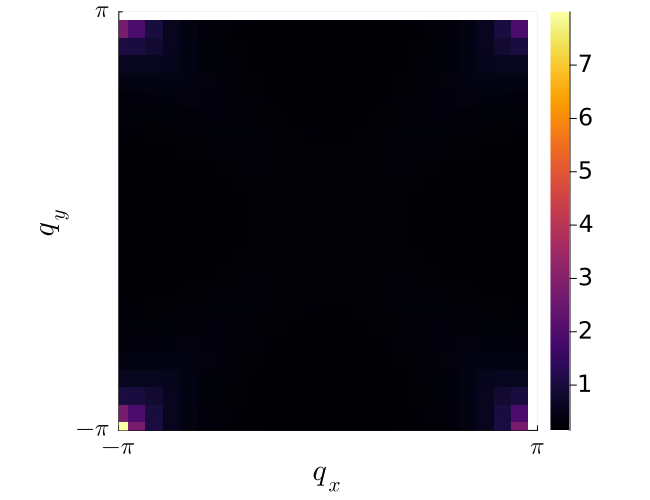

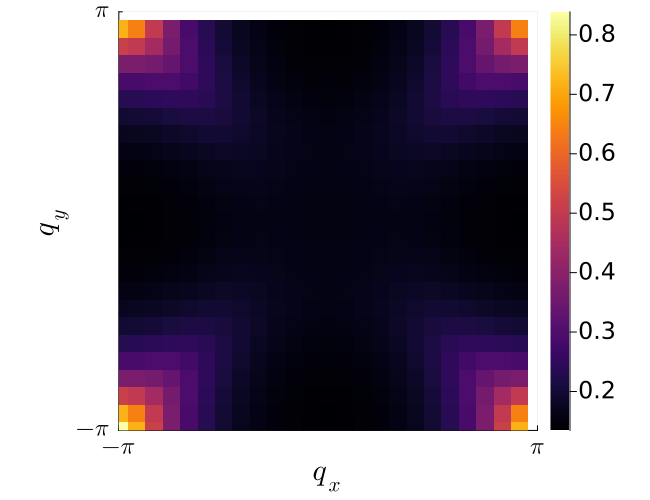

In [13]:
let
    system::String = "square"
    n_fill::Float64 = 1.0
    U::Float64 = 2.0
    T::Float64 = 0.22
    mode::String = "RPA"
    nk1::Int64 = 24
    nk2::Int64 = 24
    nk3::Int64 = 1
    nω::Int64 = 256
    op = [1/sqrt(2);;]

    p = Parameters(system, n_fill, U, T, mode; nk1, nk2, nk3, nω)
    m = Mesh(p)
    g = Gfunction(m)

    println("##################################################")
    println("Parameter set: n = $n_fill, U = $U, T = $T")
    println("emin = $(m.emin), emax = $(m.emax); μ = $(m.μ)")

    # RPA
    calc_Gfunction!(m, g)
    χs_RPA = calc_multipole_susceptibility(m, g, op)

    # FLEX
    p.mode = "FLEX"
    g = Gfunction(m)

    calc_Gfunction!(m, g)
    χs_FLEX = calc_multipole_susceptibility(m, g, op)

    println("##################################################")

    # 感受率のカラーマップを出力
    isdir("images") || mkdir("images")
    plt = plot_χ_map(real.(χs_RPA[m.iω0_b, :, :, 1]))
    display(plt)
    savefig(plt, "images/susceptibility_$(system)_RPA.png")

    plt = plot_χ_map(real.(χs_FLEX[m.iω0_b, :, :, 1]))
    display(plt)
    savefig(plt, "images/susceptibility_$(system)_FLEX.png")
end
;

### 異方的正方格子ハバード模型における反強磁性(交替磁性)秩序

##################################################
Parameter set: n = 1.0, U = 2.0, T = 0.15
emin = -4.3, emax = 3.6999999999999997; μ = -0.045574389607532045
### Check for renormalization max(χ0*U): 0.9841365604747532, U = 2.0
New U value: 2.0 with max(χ0*U) = 0.9841365604747532
1: 0.9468320784162308, μ = -0.004556855652343227
2: 0.47010759842202865, μ = -0.013661731852188901
3: 0.3076431581920433, μ = -0.01722372672196206
4: 0.20975651903486559, μ = -0.019232711128244245
5: 0.14589163667924254, μ = -0.02047215742334362
6: 0.10273451947997797, μ = -0.02127190011056077
7: 0.07299239254334286, μ = -0.021801398035096883
8: 0.05223642536633634, μ = -0.02215742877298024
9: 0.037622389975549904, μ = -0.02239907225786698
10: 0.027261754996740342, μ = -0.022563960558016686
11: 0.019873719030062135, μ = -0.022676764473498992
12: 0.014577330475627674, μ = -0.022753975984266355
13: 0.010760732996975891, μ = -0.02280676544964356
14: 0.008017755740939334, μ = -0.022842764867917666
15: 0.0060239458

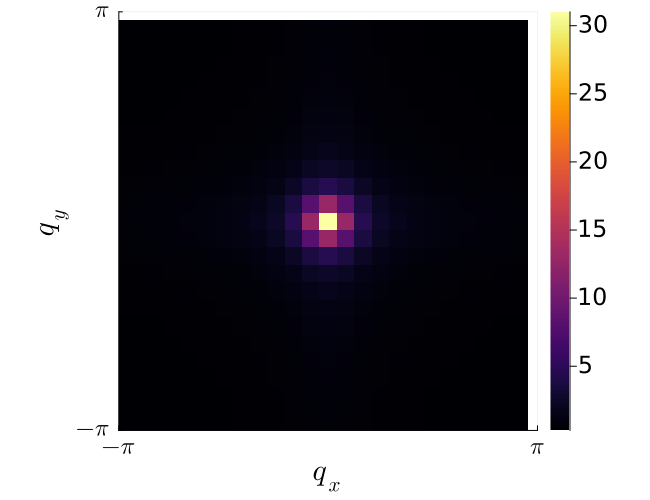

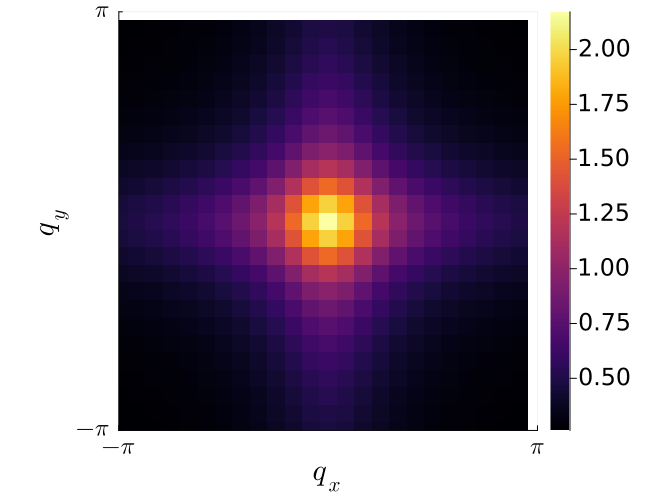

In [14]:
let
    system::String = "modified_square"
    n_fill::Float64 = 1.0
    U::Float64 = 2.0
    T::Float64 = 0.15
    mode::String = "RPA"
    nk1::Int64 = 24
    nk2::Int64 = 24
    nk3::Int64 = 1
    nω::Int64 = 256
    op = σ3 ./ sqrt(2)

    p = Parameters(system, n_fill, U, T, mode; nk1, nk2, nk3, nω)
    m = Mesh(p)
    g = Gfunction(m)

    println("##################################################")
    println("Parameter set: n = $n_fill, U = $U, T = $T")
    println("emin = $(m.emin), emax = $(m.emax); μ = $(m.μ)")

    # RPA
    calc_Gfunction!(m, g)
    χs_RPA = calc_multipole_susceptibility(m, g, op)

    # FLEX
    p.mode = "FLEX"
    g = Gfunction(m)

    calc_Gfunction!(m, g)
    χs_FLEX = calc_multipole_susceptibility(m, g, op)

    println("##################################################")

    # 感受率のカラーマップを出力
    isdir("images") || mkdir("images")
    plt = plot_χ_map(real.(χs_RPA[m.iω0_b, :, :, 1]))
    display(plt)
    savefig(plt, "images/susceptibility_$(system)_RPA.png")

    plt = plot_χ_map(real.(χs_FLEX[m.iω0_b, :, :, 1]))
    display(plt)
    savefig(plt, "images/susceptibility_$(system)_FLEX.png")
end
;